In [1]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

In [2]:
#============================================
# 1. 直交表ファイル読み込む
#============================================
# 直交表データをCSVファイルから読み込み（1列目をインデックスとして設定）
df_design = pd.read_csv('直交表.csv', index_col=0, header=0)

# 属性名（直交表のインデックス）をリスト形式で取得
attributes = df_design.index.tolist()

In [4]:
#============================================
# 2. データを縦持ち（ロング形式）に変換
#============================================
# 直交表の行列を転置して、選択肢番号を列に変更
df_long = df_design.T.reset_index().rename(columns={'index':'選択肢番号'})

# 選択肢番号を文字列から整数型に変換（データ型の統一のため）
df_long['選択肢番号'] = df_long['選択肢番号'].astype(int)

#============================================
# 3. 調査データファイル読み込み
#============================================
df_survey = pd.read_csv('調査データ.csv')

#============================================
# 4. QA_0～QA_8を縦持ち化（meltで整形）
#============================================
# 対象列（9つの評価項目）をリストで定義
qa_cols = [f'QA_{i}' for i in range(9)]

# IDとOS(ブランド)をキーとして、QA列を縦持ちに変換
df_melt = df_survey.melt(id_vars=['ID', 'OS(ブランド）'], value_vars=qa_cols, var_name='QA', value_name='評価値')
# 'QA'列から文字列 'QA_' を取り除き、数値（選択肢番号）に変換
df_melt['選択肢番号'] = df_melt['QA'].str.replace('QA_', '').astype(int)
#============================================
# 5. 属性水準データと評価データを結合（選択肢番号をキーに）
#============================================
df_merged = pd.merge(df_melt, df_long, on='選択肢番号', how='left')
df_merged

,ID,OS(ブランド）,QA,評価値,選択肢番号,OS（ブランド）,バッテリー,画面サイズ,価格
0,1,iPhone,QA_0,2,0,iPhone,3000mAh,5インチ,6万
1,2,Android,QA_0,0,0,iPhone,3000mAh,5インチ,6万
2,3,Galaxy M51,QA_0,0,0,iPhone,3000mAh,5インチ,6万
3,4,iPhone,QA_0,1,0,iPhone,3000mAh,5インチ,6万
4,5,Android,QA_0,2,0,iPhone,3000mAh,5インチ,6万
...,...,...,...,...,...,...,...,...,...
805,86,Galaxy M51,QA_8,2,8,Galaxy M51（高バッテリー）,6500mAh,6インチ,6万
806,87,Galaxy M51,QA_8,0,8,Galaxy M51（高バッテリー）,6500mAh,6インチ,6万
807,88,Android,QA_8,0,8,Galaxy M51（高バッテリー）,6500mAh,6インチ,6万
808,89,Android,QA_8,-2,8,Galaxy M51（高バッテリー）,6500mAh,6インチ,6万


In [5]:
#============================================
# 6. 属性水準のカテゴリ変数をダミー変数化
#============================================
df_dummies = pd.get_dummies(df_merged[attributes])

#============================================
# 7. 全体効用値の推定
#============================================
# 属性水準のダミー変数をXに
X_all = pd.get_dummies(df_merged[attributes])

# 評価値（目的変数）をyに
y_all = df_merged['評価値']

# モデルを学習・推定
model_all = sm.OLS(y_all, X_all)
res_all = model_all.fit()

# 結果の表示
#print("=== 全体効用値 ===")
#print(res_all.params)


In [6]:
#============================================
# 8. 現在使用中のOS（ブランド）効用値推定
#============================================
manufacturer_utilities = []

# OSごとにグループ化し、OLS回帰を実行
for manu, group in df_merged.groupby('OS（ブランド）'):
    X = pd.get_dummies(group[attributes])
    y = group['評価値']
    model = sm.OLS(y, X)
    res = model.fit()
    coef = res.params
    
   # ダミー列すべてを揃えて、値が無いところは0に（穴埋め）
    coef_full = pd.Series(0, index=df_dummies.columns)
    coef_full.update(coef)
    
    # 使用中のOS（ブランド）名を保持
    coef_full['OS（ブランド）'] = manu
    manufacturer_utilities.append(coef_full)

# 各ブランドごとの効用値をまとめたDataFrameに変換
df_manufacturer_util = pd.DataFrame(manufacturer_utilities)

#============================================
# 列名から属性名のprefixを削除して水準名だけに
#============================================
def rename_cols(col):
    for attr in attributes:
        if col.startswith(attr + '_'):
            return col.replace(attr + '_', '', 1)
    return col
    

df_manufacturer_util = df_manufacturer_util.rename(columns=rename_cols)

# OS（ブランド）列を先頭に移動
cols = ['OS（ブランド）'] + [c for c in df_manufacturer_util.columns if c != 'OS（ブランド）']
df_manufacturer_util = df_manufacturer_util[cols]

#print("\n===現在使用中のOS（ブランド）別効用値 ===")
#print(df_manufacturer_util)



C:\Users\user\AppData\Local\Programs\Python\Python38\lib\site-packages\pandas\core\dtypes\cast.py:2221: RuntimeWarning: invalid value encountered in cast
  casted = element.astype(dtype)
C:\Users\user\AppData\Local\Programs\Python\Python38\lib\site-packages\pandas\core\dtypes\cast.py:2221: RuntimeWarning: invalid value encountered in cast
  casted = element.astype(dtype)
C:\Users\user\AppData\Local\Programs\Python\Python38\lib\site-packages\pandas\core\dtypes\cast.py:2221: RuntimeWarning: invalid value encountered in cast
  casted = element.astype(dtype)


In [7]:
#============================================
# 9. ID別効用値推定 
#============================================

utility_list = []
for id_, group in df_merged.groupby('ID'):
    X = pd.get_dummies(group[attributes])
    y = group['評価値']
    model = sm.OLS(y, X)
    res = model.fit()

    coef = res.params
    coef_full = pd.Series(0, index=df_dummies.columns)
    coef_full.update(coef)
    coef_full['ID'] = id_
    utility_list.append(coef_full)

df_utility = pd.DataFrame(utility_list)
df_utility = df_utility.rename(columns=rename_cols)



# --- スマホメーカをマージ ---
df_utility = df_utility.merge(df_survey[['ID', 'OS(ブランド）']], on='ID', how='left')

# 列順：ID → スマホメーカ → 効用値列
cols = ['ID', 'OS(ブランド）'] + [c for c in df_utility.columns if c not in ['ID', 'OS(ブランド）']]
df_utility = df_utility[cols]





In [9]:
#============================================
# 10. CSV保存
#============================================
df_utility.to_csv('効用値_ID別.csv', index=False, encoding="utf-8-sig")
df_manufacturer_util.to_csv('効用値_現在使用中のOS（ブランド）別効用値別.csv', index=False, encoding="utf-8-sig")
pd.DataFrame(res_all.params, columns=['効用値']).to_csv('効用値_全体.csv', encoding='utf-8-sig')




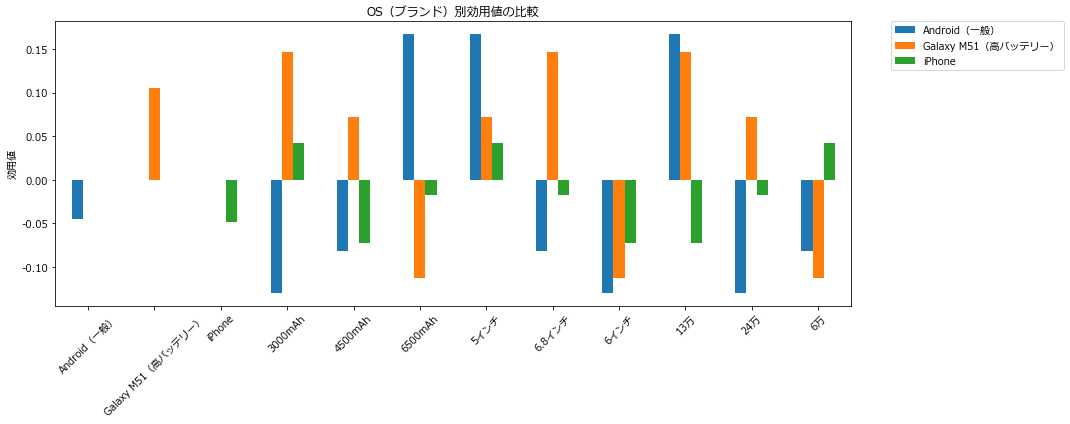

In [10]:
# 現在使用中のOS（ブランド）別の効用値でグラフを作成
# 一時的に警告オフ
with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    # 日本語フォント設定（簡易版）
    plt.rcParams['font.family'] = 'Meiryo'  # WindowsならMeiryoが安全、MacならHiragino系

    plt.rcParams['axes.unicode_minus'] = False  # マイナス符号の文字化け防止

    # データの整形とプロット
    df_manuf_plot = df_manufacturer_util.set_index('OS（ブランド）').T
    df_manuf_plot.plot(kind='bar', figsize=(15, 6))

    # 凡例を右側の外に出す
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

    plt.title('OS（ブランド）別効用値の比較')
    plt.ylabel('効用値')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

